### Data exploring

<font size="4"> Let's look at the data without any preprocesses steps, if we are lucky enough, we may find something interesting
</font>

In [174]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

In [175]:
import pandas as pd
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import urllib3.request
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# %matplotlib widget

In [176]:
df = pd.read_json("../data/dataset.v1.issues.json")

<font size="4">
let's try select set of fields, that we think can help us and look at the report 
</font>

### First hypothesis
<font size="4">
we have enough datapoints in labels field if so, the task can be solved as the classification one
</font>

In [177]:
import json
with open("../data/dataset.v1.issues.json") as file:
    data = json.load(file)

In [178]:
label_list = [issue['labels'] for issue in data['issues'] if 'labels' in issue]
label_dataset = []
for labels in label_list:
     label_dataset.append([label['name'] for label in labels if 'name' in label])
df = pd.DataFrame(label_dataset)

### Results of the investigating of first hypothesis

In [179]:
print('1. Number of datapoints:', df.shape[0])
print('2. Number of datapoints with at least one tag:', df.shape[0] -  df[0].isnull().sum())
print('3. Number of datapoints with at least 2 tags', df.shape[0] - df[1].isnull().sum())

1. Number of datapoints: 5661
2. Number of datapoints with at least one tag: 3429
3. Number of datapoints with at least 2 tags 2311


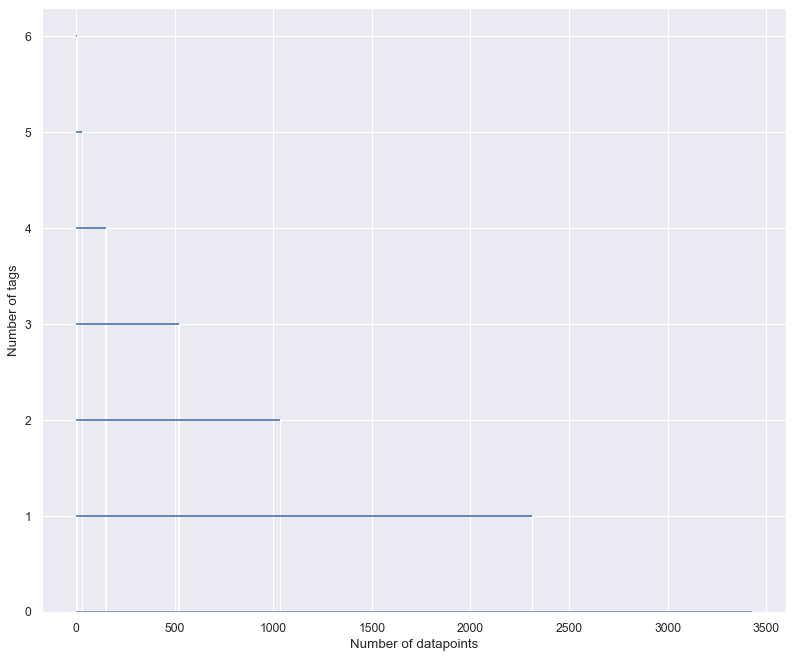

In [180]:
x = [df.shape[0] - df[i].isnull().sum() for i in range(7)]

plt.figure(figsize=(12, 10), dpi=80)
plt.bar(x,[i for i in range(7)],align='center') 
plt.xlabel('Number of datapoints')
plt.ylabel('Number of tags')
for i in range(7):
    plt.hlines(i,0,x[i])
plt.show()

<font size="4">
So we have pretty huge number of datapoints with at least one tag. But are they really helpful? I mean, is this label truly display severity of the puzzle?
</font>

In [181]:
import itertools

In [182]:
tags = [tag for tag in list(itertools.chain(*[list(df[i]) for i in range(7)])) if not pd.isnull(tag)]
tags_text = ' '.join(tags)
word_cloud = WordCloud(width=1800, height=1200,collocations = False, background_color = 'white').generate(tags_text)

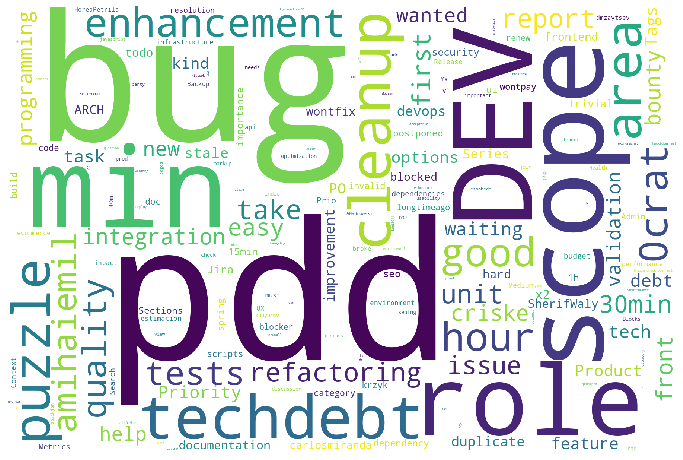

In [183]:
plt.figure(figsize=(12, 10))
plt.imshow(word_cloud, interpolation='nearest')
plt.axis("off")
plt.show()

In [184]:
word_dist = nltk.FreqDist(tags)
rslt=pd.DataFrame(word_dist.most_common(20),columns=['Word','Frequency'])

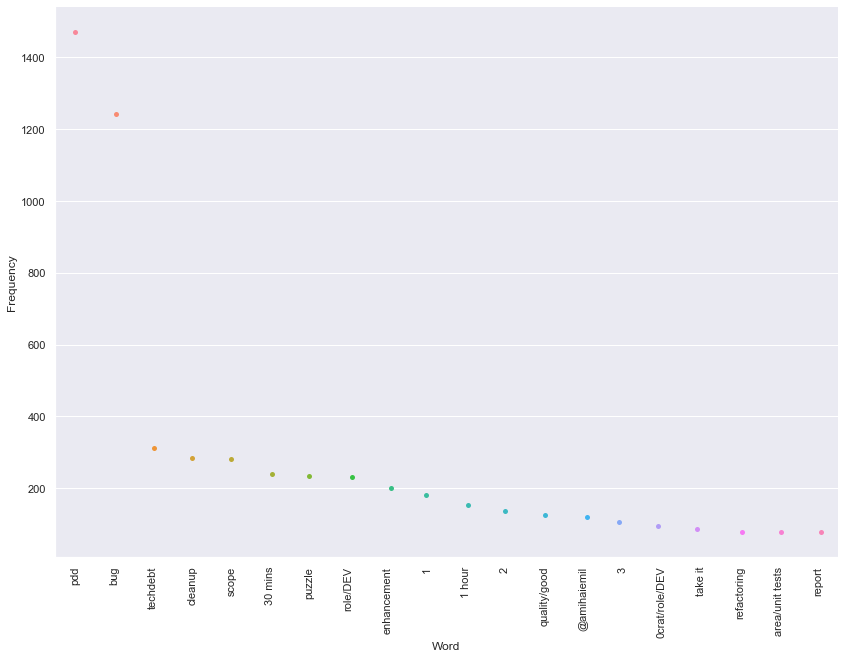

In [185]:
sns.catplot(x='Word', y='Frequency',data = rslt,height=8.27, aspect=11.7/8.27);
plt.xticks(rotation=90);

### From the observed data i can make several conclusion:
1. There are some good labels of puzzles, that actually contains information about severity of the bug, or the importance for the client, like: hour, easy, enhancement, first, documentation, techdebt. 
2. Most of the puzzles contains labels, which is not very relevant to the ranking task, for example can we understand the importance of task with label bug or pdd?

### As the conclusion for the first hypothesis, i propose to not to use the label field

### Second hypothesis: if task is hard, many puzzles will be created, so if we have a long series of related puzzles, we can think of it as a one feature that need to be implemented. Longer the puzzle chain, then more importantly will be head of the chain

In [186]:
df = pd.read_csv('../data/all-puzzles.csv')
df['Parent ID'].isnull().sum()

10500

<font size="4">
All puzzles do not have parent data, which means that we do not have data of relation of puzzles
</font>

### At this moment, we can't use this approach

### Another approach

<font size="4">
If task is hard many people will be involved into this task, so we can predict the rating of the task, by predicting number of comments to the issue
</font>

In [187]:
with open('../data/dataset.v3.issues_extended_urls.json') as f:
    comments_count = []
    data = json.loads(f.read())
    data = [issue for issue in data['issues'] if 'comments_url' in issue]
    for issue in data:
        comments_count.append(len(issue['comments_url']))

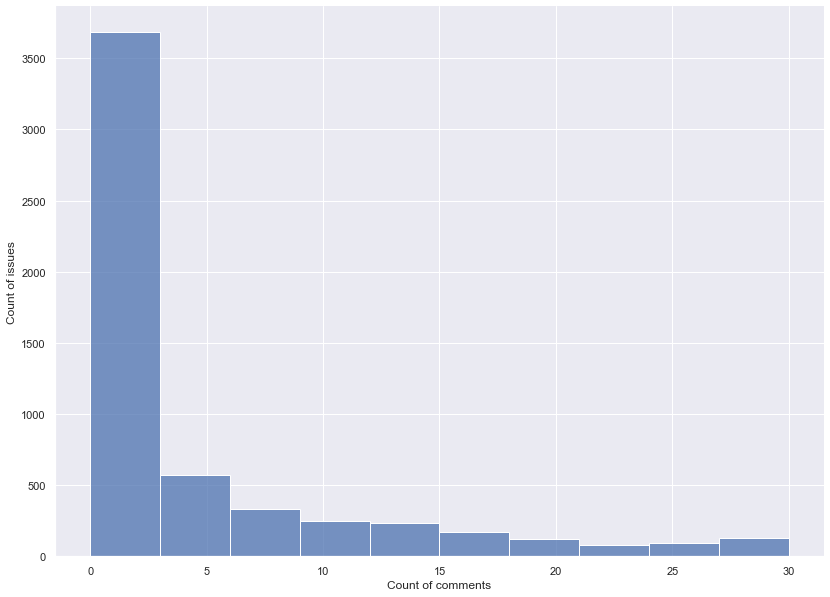

In [188]:
ax = sns.displot(comments_count,binwidth=3, height=8.27, aspect=11.7/8.27)
ax.set(xlabel='Count of comments', ylabel='Count of issues')

In [189]:
print('Count of issues where count of messages at least one: ', len(list(filter(lambda x: x >= 1,comments_count))))
print('Count of issues where count of messages is zero: ', len(list(filter(lambda x: x == 0, comments_count))))

Count of issues where count of messages at least one:  4517
Count of issues where count of messages is zero:  1144


<font size="4">
So even if we have very unbalanced data, where most of the issues have number of comments is less then 5, we could try this approach, when we predicting the rank of the puzzle, but predicting the count of comments 
</font>

In [190]:
import json
import seaborn as sns
with open('../data/dataset.v3.issues_extended_urls.json') as f:
    events_type = []
    data = json.loads(f.read())
    data = [issue for issue in data['issues'] if 'events_url' in issue]
    for issue in data:
        events_type.extend([event['event'] for event in issue['events_url']])

/Users/mbao01/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



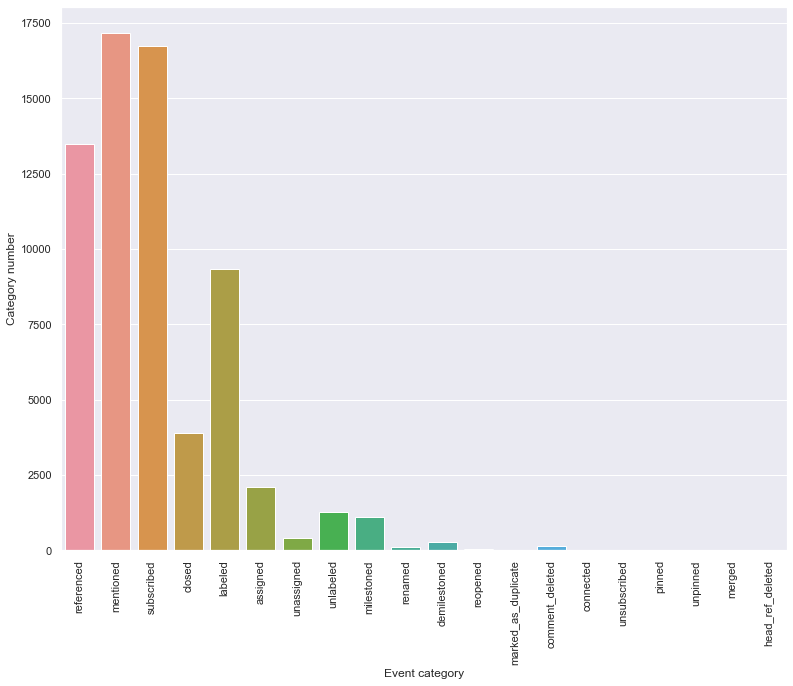

In [191]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(13,10)})
ax = sns.countplot(events_type)#binwidth=3, height=8.27, aspect=11.7/8.27)
ax.set(xlabel='Event category', ylabel='Category number')
plt.xticks(rotation=90);

In [192]:
import json
import seaborn as sns
with open('../data/dataset.v3.issues_extended_urls.json') as f:
    actors_list = []
    data = json.loads(f.read())
    data = [issue for issue in data['issues'] if 'events_url' in issue]
    for issue in data:
        actors = ([event['actor'] for event in issue['events_url'] if 'actor' in event and event['actor']])
        actors_list.extend([actor['repos_url'] for actor in actors if 'repos_url' in actor])
            

In [193]:
sns.set()
sns.set(font_scale=1.55);

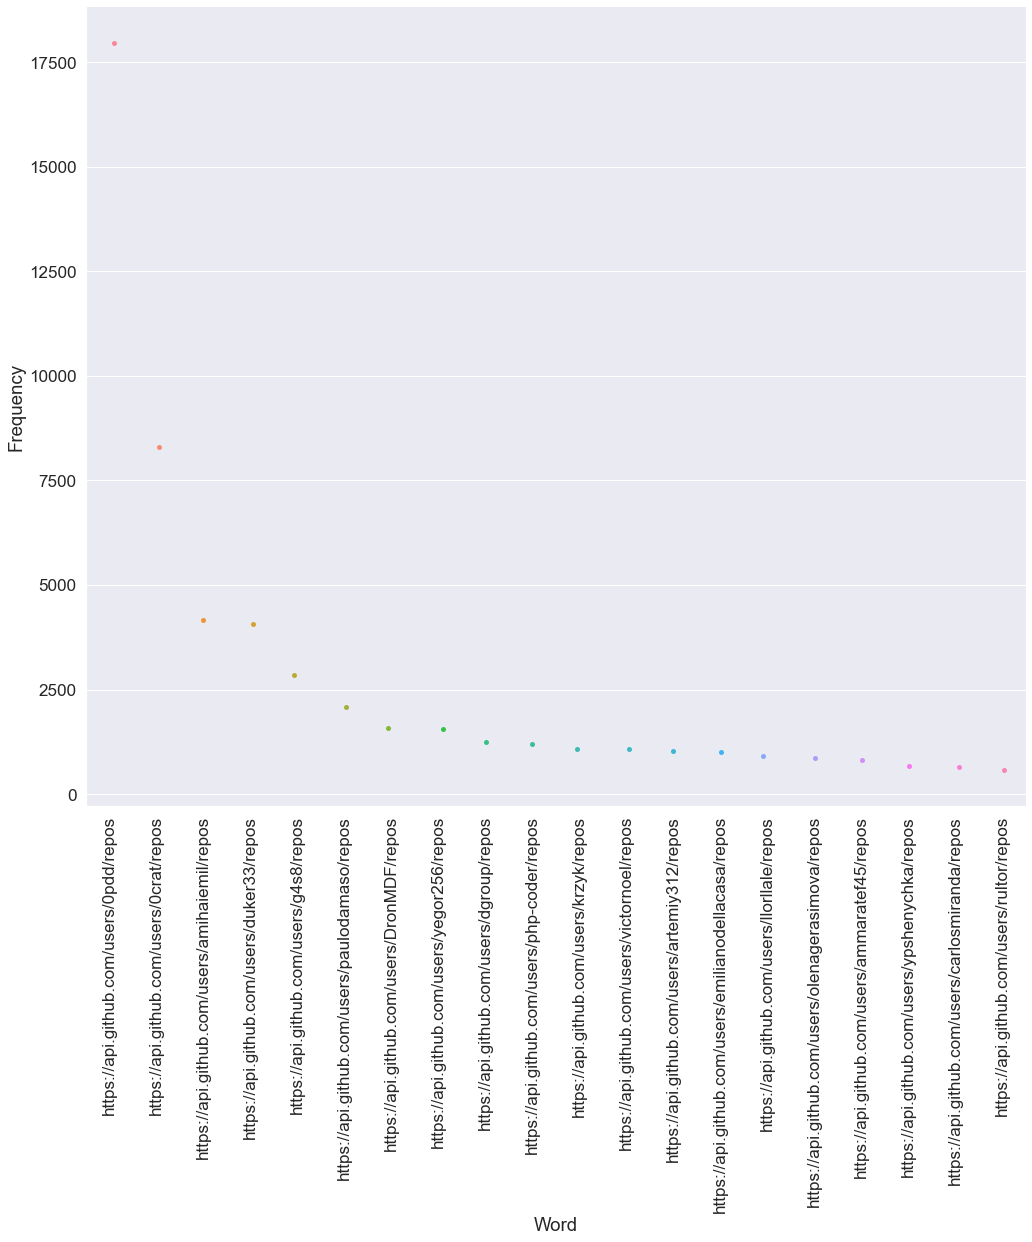

In [194]:
import nltk
import pandas as pd
word_dist = nltk.FreqDist(actors_list)
rslt=pd.DataFrame(word_dist.most_common(20),columns=['Word','Frequency'])
sns.catplot(x='Word', y='Frequency',data = rslt,height=12, aspect=11.7/8.27);
plt.xticks(rotation=90);

# import matplotlib.pyplot as plt
# sns.set(rc={'figure.figsize':(13,10)})
# ax = sns.countplot(actors_list)#binwidth=3, height=8.27, aspect=11.7/8.27)
# ax.set(xlabel='Event category', ylabel='Category number')
# plt.xticks(rotation=90);

In [195]:
import json
import seaborn as sns
from dateutil.parser import parse

fls = [f'../data/extended-issues-{i}.json' for i in range(3)]

def r(f):
    with open(f) as f:
        events_type = []
        data = json.loads(f.read())
    return data

In [196]:
def get_row(issue):
    def _(f):
        return issue[f] if f in issue else None
    
    def _t(f1, f2):
        return (parse(_(f2)) - parse(_(f1))).total_seconds() if _(f1) and _(f2) else None 
    
    def __(f1, f2):
        return _(f1)[f2] if _(f1) and f2 in _(f1) else None
    
    def _l():
        return [label['name'] for label in _('labels')] if _('labels') else []
    
    time_delta = _t('created_at', 'closed_at')
    number_of_assignees = len(_('assignees') or [])
    changes = [__('code', 'additions') or 0,
               __('code', 'deletions') or 0
              ]
    
    comment_count = _('referenced') or 0
    mentioned = _('mentioned') or 0
    subscribed = _('subscribed') or 0
    number_of_files = len(__('all_commits','files') or [])
    labels = _l()
    return [time_delta, number_of_assignees, *changes, comment_count, mentioned, subscribed,number_of_files, *labels]

In [197]:
columns = ['time_delta', 'number_of_assignees', 'changes', 'comment_count', 'mentioned', 'subscribed','number_of_files', 'labels'] 

In [230]:
overall_data = []
all_issues = []
for f in fls:
    data = r(f)
    all_issues.extend(data)
    overall_data.extend([get_row(issue) for issue in data if issue.get('state', None) == 'closed'])

In [231]:
print(overall_data[0])
closed_len = len([i for i in all_issues if i.get('state', None) == 'closed'])
issues_len = len(all_issues)
open_len = len([i for i in all_issues if i.get('state', None) == 'open'])

print(f'No. of open issues {open_len}')
print(f'No. of closed issues {closed_len}')
print(f'Total no. of issues {issues_len}')

[103.0, 0, 2, 2, 2, 0, 0, 0]
No. of open issues 1509
No. of closed issues 4161
Total no. of issues 10489


In [199]:
pd_data = pd.DataFrame(overall_data)

In [200]:
import category_encoders as ce
encoder = ce.CountEncoder(normalize=True)
encoder.fit(np.array(list(itertools.chain(*pd_data.iloc[:,8:].to_numpy()))))
for i in range(8,15):
    pd_data.iloc[:,i] = encoder.transform(pd_data.iloc[:,i])[0]

In [201]:
scaler = MinMaxScaler()
scaler.fit(pd_data)
pd_data.iloc[:,:8] = scaler.fit_transform(pd_data.iloc[:,:8])

In [202]:
pd_data = pd_data.dropna()

In [203]:
svd = TruncatedSVD(n_components=3, n_iter=10, random_state=42)
truncated = svd.fit_transform(pd_data)

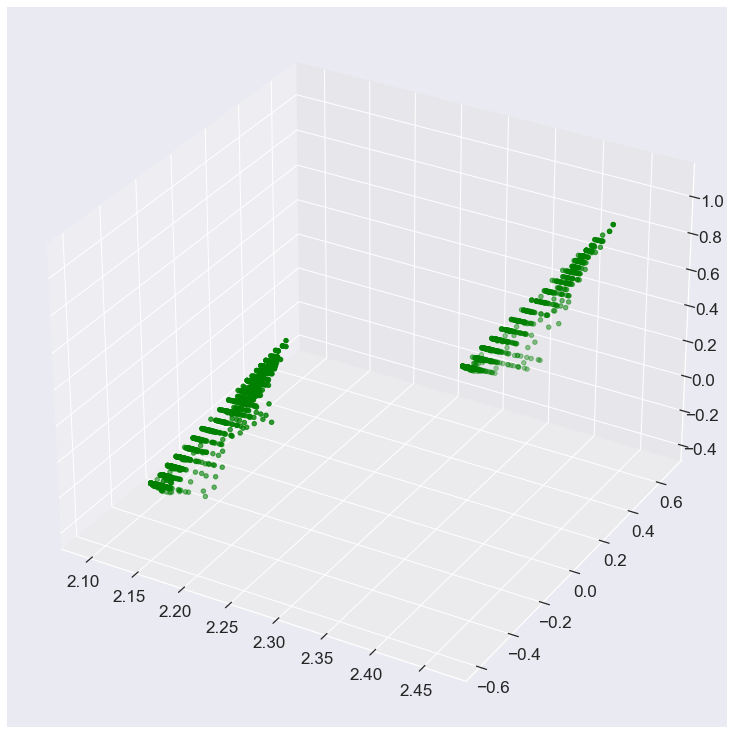

In [204]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(truncated[:,0], truncated[:,1], truncated[:,2], color='green')
plt.show()

In [205]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

trace = go.Scatter3d(
    x= truncated[:,0],  
    y= truncated[:,1], 
    z= truncated[:,2],  
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)
plotly.offline.iplot(plot_figure)

In [206]:
svd.explained_variance_ratio_.sum()

0.9374994440211427

In [207]:
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
reduced_data = svd.fit_transform(pd_data)
X = np.array(reduced_data)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

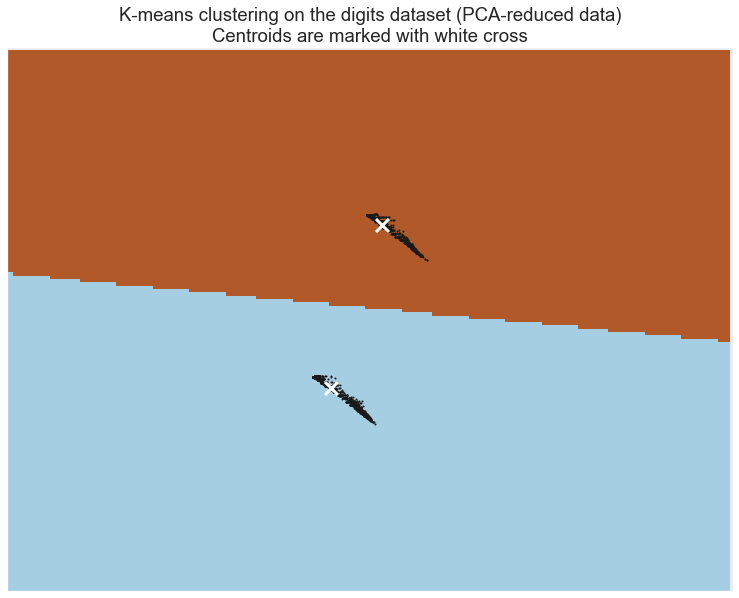

In [208]:
h = .02 

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

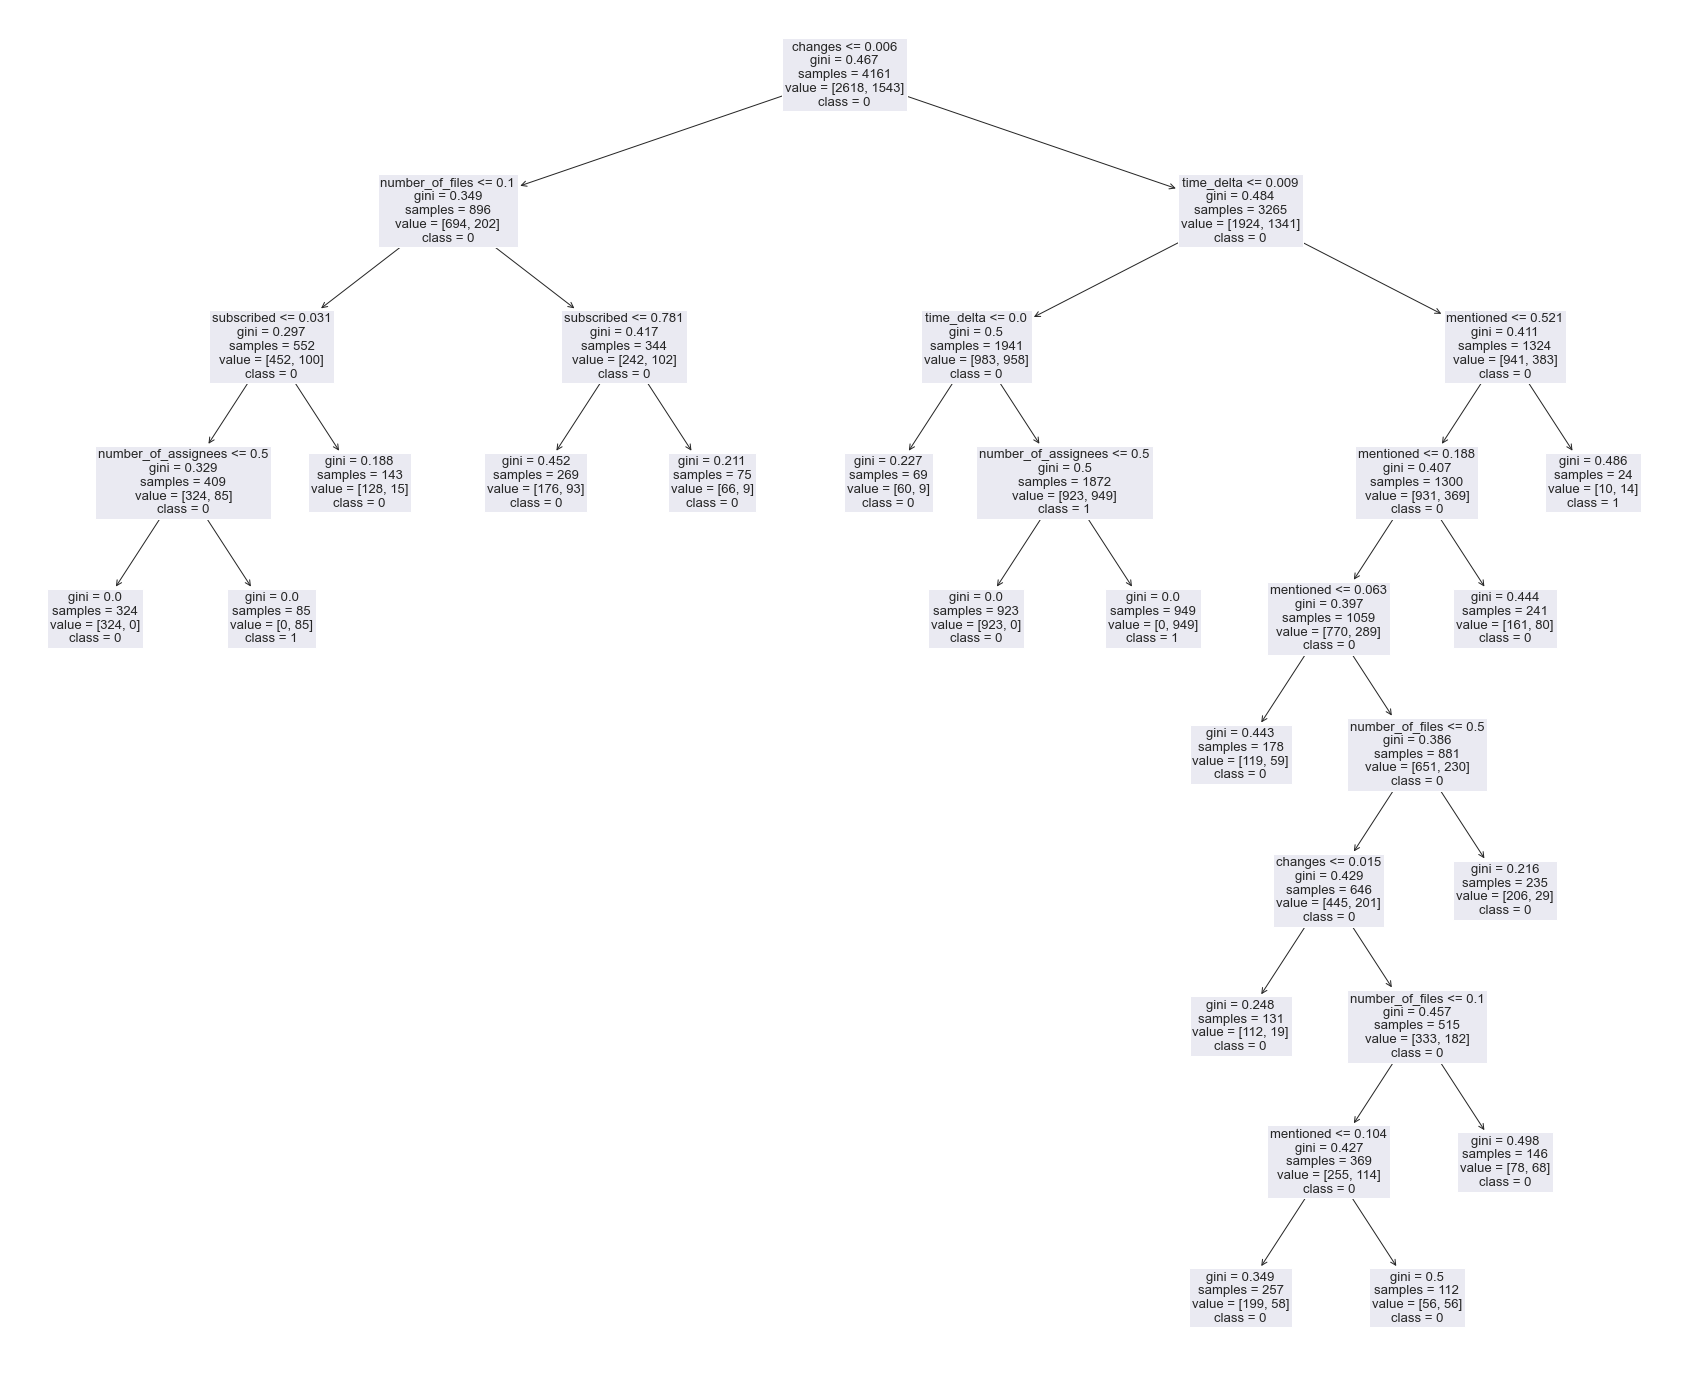

In [209]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(random_state=42, max_features='log2', min_samples_split=300,)
clf.fit(np.array(pd_data), kmeans.predict(X))
fig = plt.figure(figsize=(30,25))
tree.plot_tree(clf, feature_names=columns, class_names=['0', '1']);

In [210]:
with open('../data/dataset.v1.issues.json') as f:
    data = json.loads(f.read())
    data = [issue.get('title', '').lower() + ' ' + issue.get('body', '').lower() for issue in data['issues']]
        

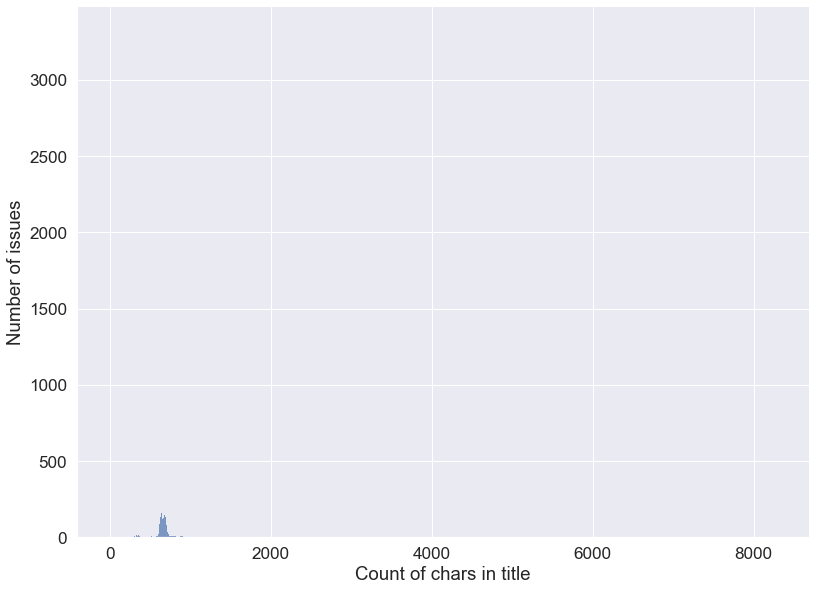

In [211]:
ax = sns.displot([len(issue) for issue in data],binwidth=3, height=8.27, aspect=11.7/8.27)
ax.set(xlabel='Count of chars in title', ylabel='Number of issues')

/Users/mbao01/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



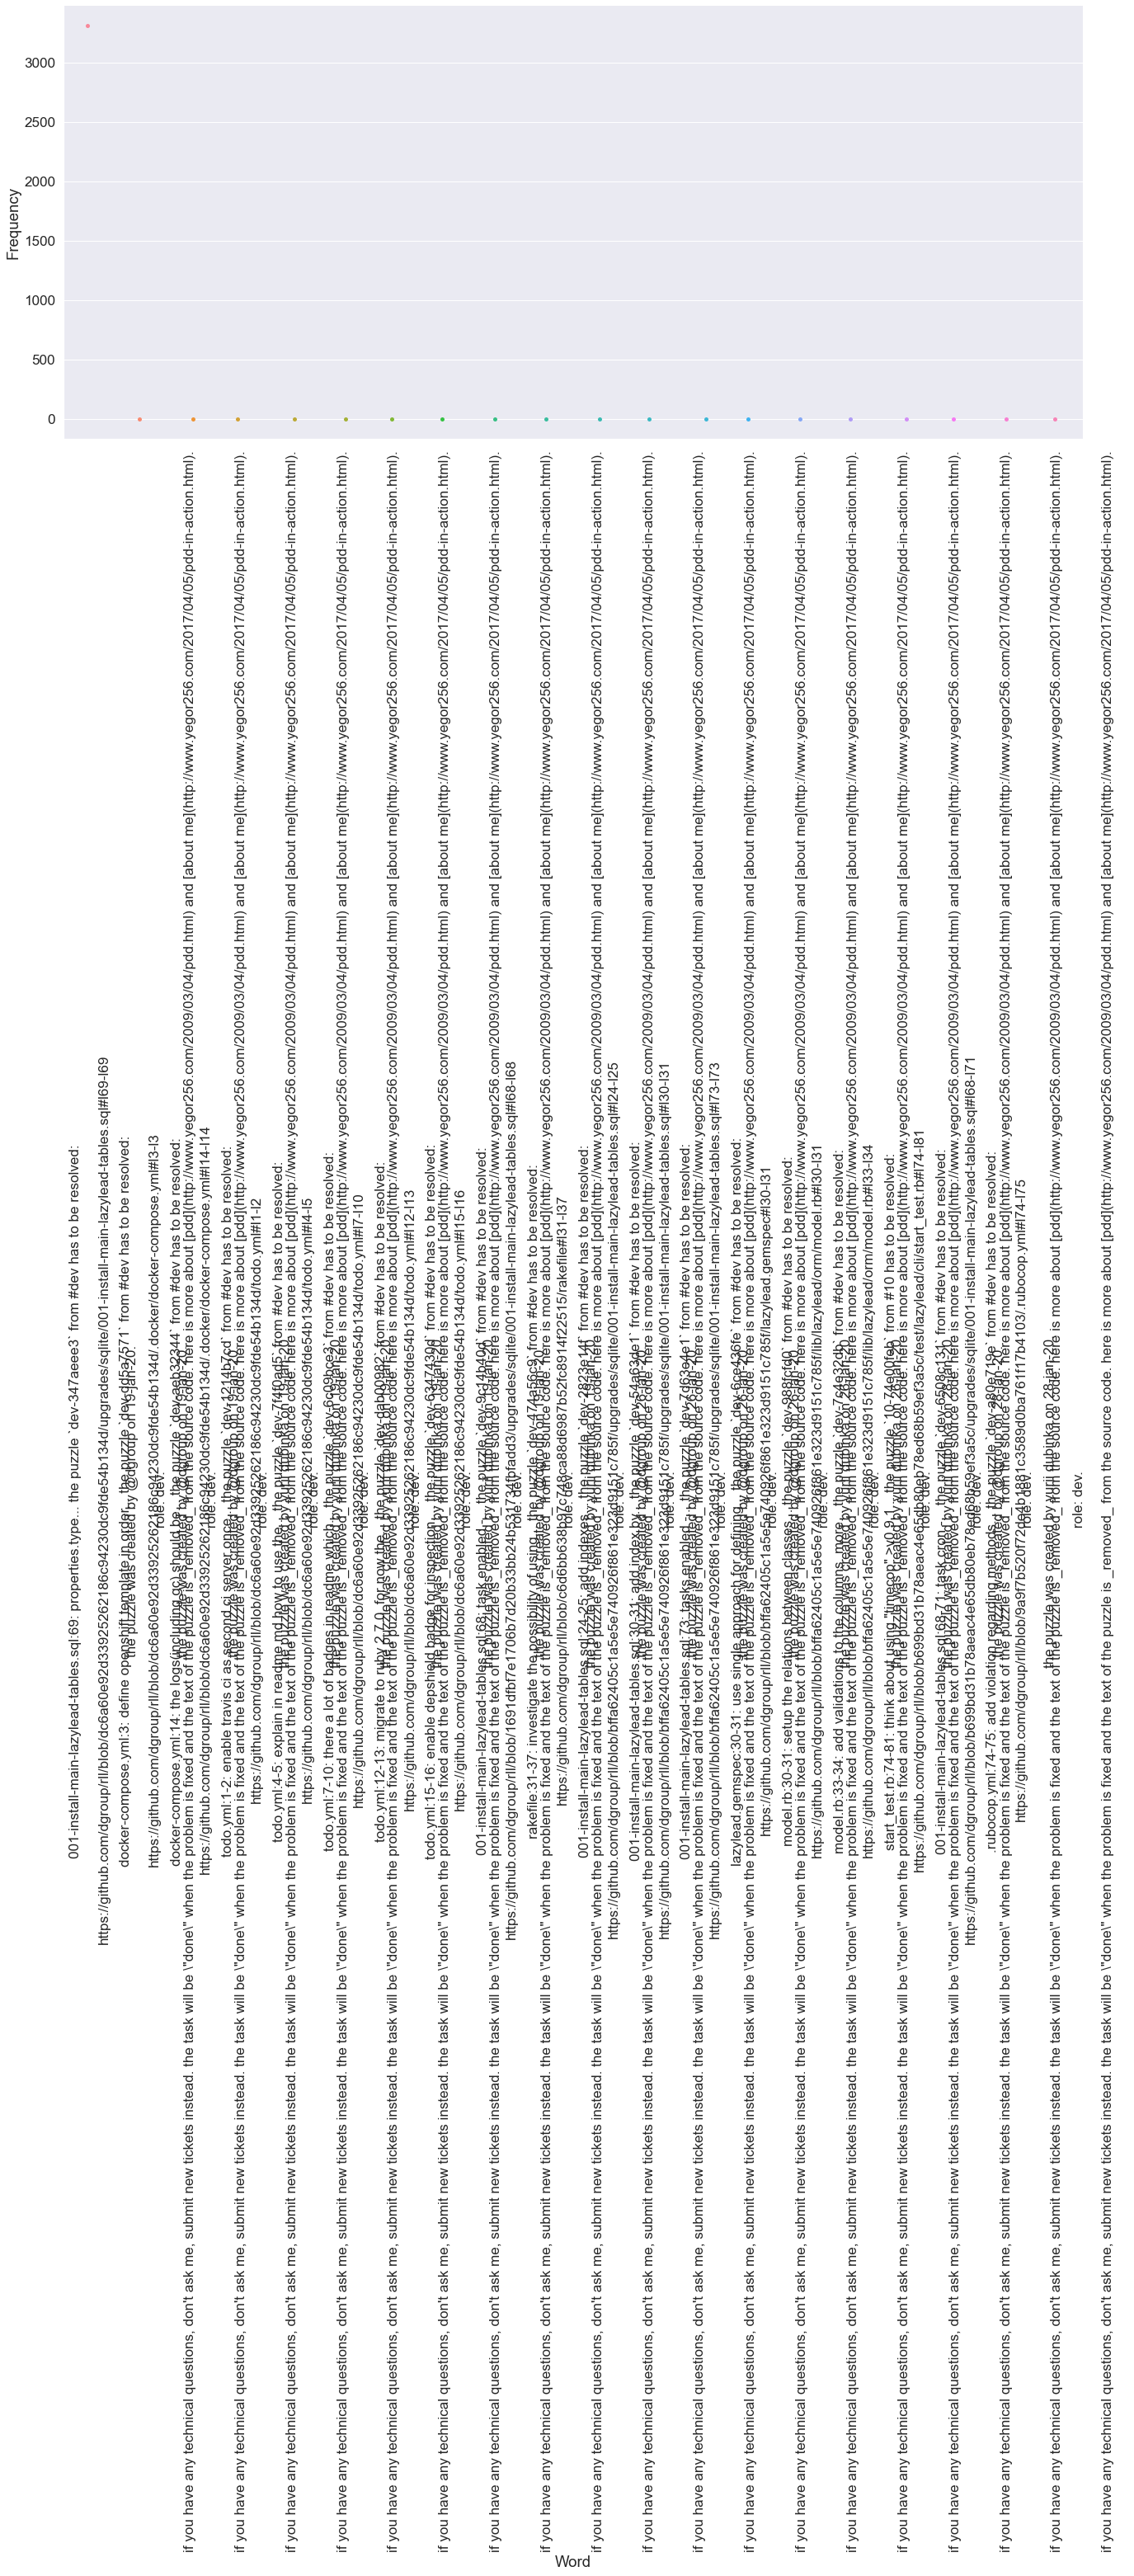

In [212]:
word_dist = nltk.FreqDist(data)
rslt=pd.DataFrame(word_dist.most_common(20),columns=['Word','Frequency'])
sns.catplot(x='Word', y='Frequency',data = rslt,height=8.27, aspect=11.7/5.27);
plt.xticks(rotation=90);

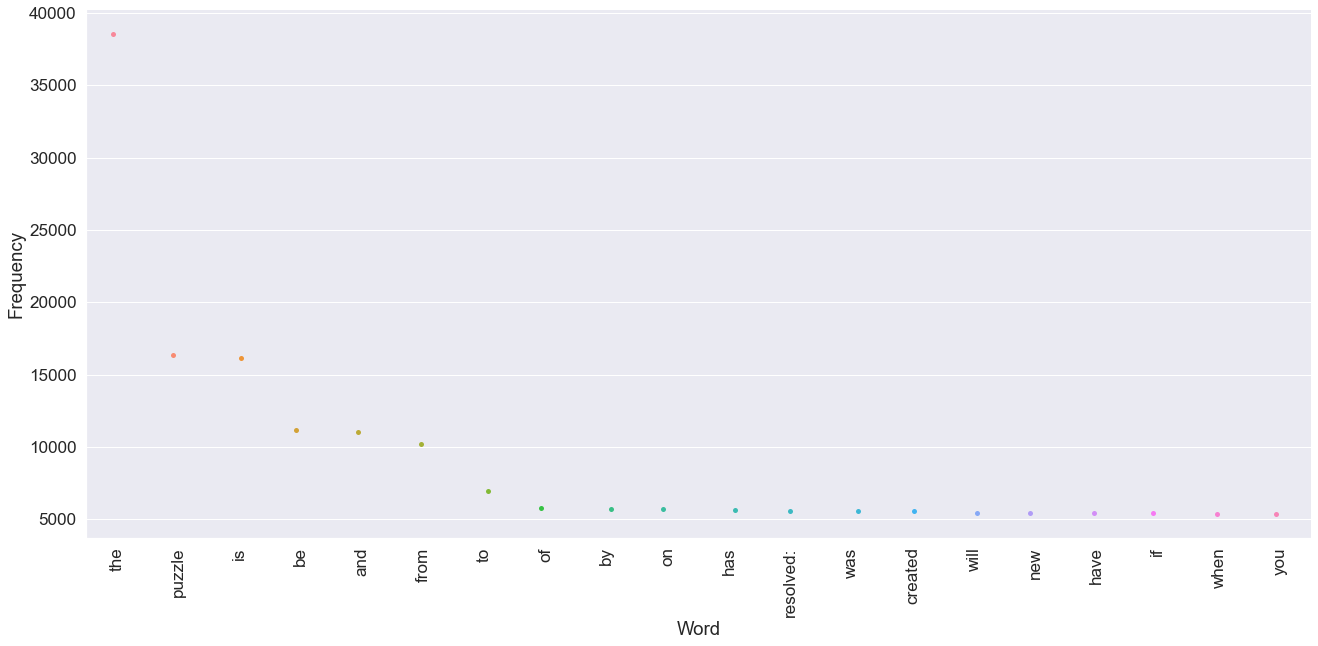

In [213]:
words = [word for sentence in data for word in sentence.split()]
word_dist = nltk.FreqDist(words)
rslt=pd.DataFrame(word_dist.most_common(20),columns=['Word','Frequency'])
sns.catplot(x='Word', y='Frequency',data = rslt,height=8.27, aspect=11.7/5.27);
plt.xticks(rotation=90);

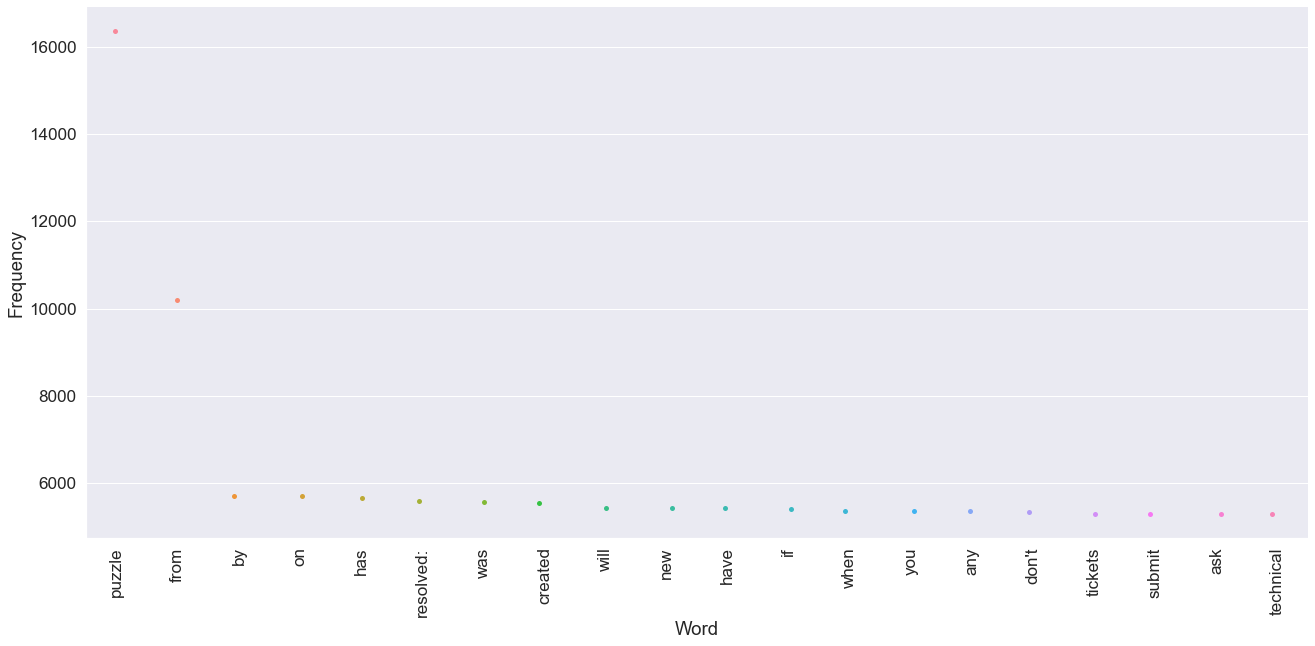

In [214]:
stop_words = ['to','the','for', 'this','a', 'and','of','is','we','be','pdd']

words = [word for word in words if word not in stop_words]
word_dist = nltk.FreqDist(words)
rslt=pd.DataFrame(word_dist.most_common(20),columns=['Word','Frequency'])
sns.catplot(x='Word', y='Frequency',data = rslt,height=8.27, aspect=11.7/5.27);
plt.xticks(rotation=90);

In [215]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

df = pd.DataFrame({'issues': data })
df['cleaned'] = df['issues'].str.replace("[^a-zA-Z#]", " ")
df['cleaned'] = df['cleaned'].apply(lambda x: np.nan if x.strip() == '' else x)
df = df[df['cleaned'].notnull()]

df = df['cleaned'].apply(lambda x: [word for word in word_tokenize(x) if len(word)>1] if x else [''])
df = df.apply(lambda x: [item for item in x if item not in stop_words])

detokenized_doc = []
for i in range(len(df)):
    if i in df:
        t = ' '.join(df[i])
        detokenized_doc.append(t)

[nltk_data] Downloading package punkt to /Users/mbao01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-215-17c823b29e13>:5: FutureWarning:

The default value of regex will change from True to False in a future version.



In [216]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer of scikit learn
vectorizer = TfidfVectorizer(max_features= 500, ngram_range=(1,3))
X = vectorizer.fit_transform(detokenized_doc)
terms = vectorizer.get_feature_names()

In [217]:

svd = TruncatedSVD(n_components=3, n_iter=10, random_state=42)
truncated = svd.fit_transform(X)

trace = go.Scatter3d(
    x= truncated[:,0],  
    y= truncated[:,1], 
    z= truncated[:,2],  
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)
plotly.offline.iplot(plot_figure)

In [218]:
svd.explained_variance_ratio_.sum()

0.16487977935494508

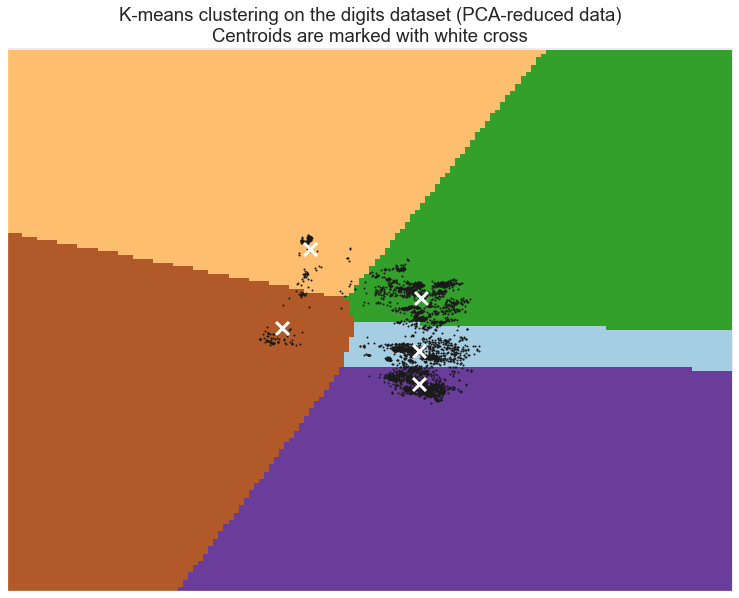

In [219]:
svd = TruncatedSVD(n_components=2, n_iter=15, random_state=42)
reduced_data = svd.fit_transform(X)
X = np.array(reduced_data)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
h = .02 

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [220]:
svd.explained_variance_ratio_.sum()

0.10749240243147687

In [221]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X, n_components=10, n_iter=100,
                              random_state=122)
#printing the concepts
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Concept "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Concept 0: 
aa
ab
 
Concept 1: 
ab
aa
 


In [222]:
import umap.umap_ as umap
X_topics=U*Sigma
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)

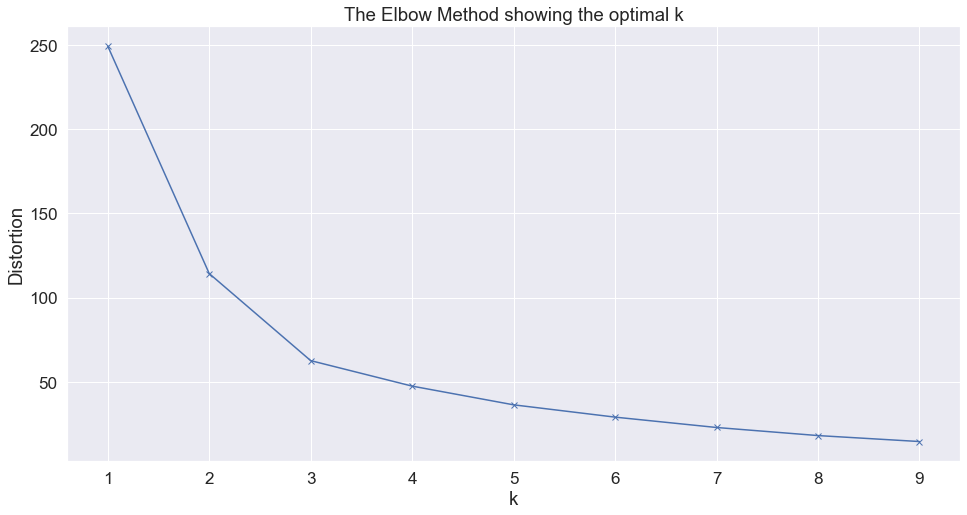

In [223]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

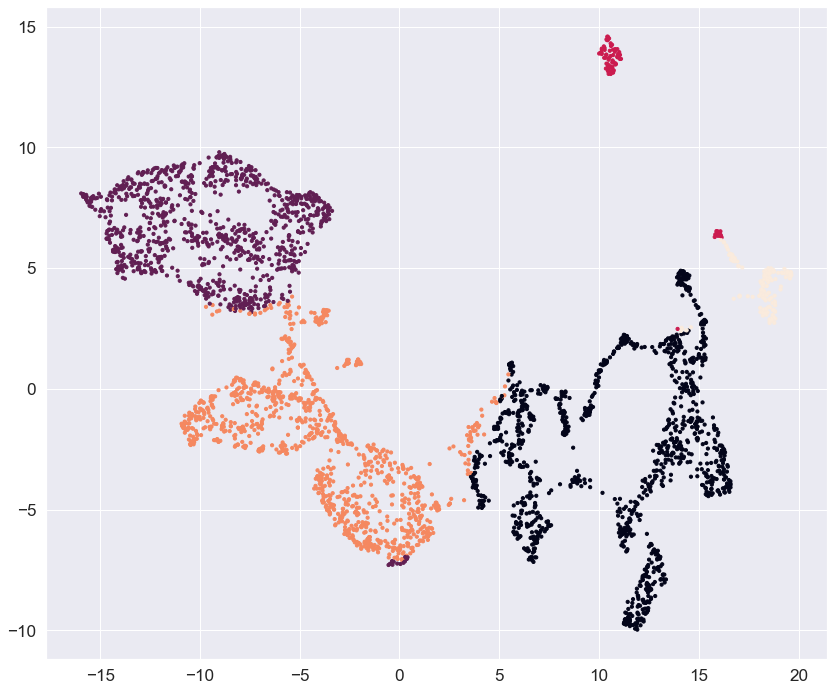

In [224]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_.tolist()
plt.figure(figsize=(14,12))
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters,s = 10,)
plt.show()